## Import Modules

In [133]:
%matplotlib inline
# %matplotlib notebook

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from urllib.request import urlopen
import pandas_profiling

plt.style.use('ggplot')

# Getting the data

In [134]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases//breast-cancer-wisconsin/wdbc.data'
names = ['id_number', 'diagnosis', 'radius_mean',
         'texture_mean', 'perimeter_mean', 'area_mean',
         'smoothness_mean', 'compactness_mean',
         'concavity_mean','concave_points_mean',
         'symmetry_mean', 'fractal_dimension_mean',
         'radius_se', 'texture_se', 'perimeter_se',
         'area_se', 'smoothness_se', 'compactness_se',
         'concavity_se', 'concave_points_se',
         'symmetry_se', 'fractal_dimension_se',
         'radius_worst', 'texture_worst',
         'perimeter_worst', 'area_worst',
         'smoothness_worst', 'compactness_worst',
         'concavity_worst', 'concave_points_worst',
         'symmetry_worst', 'fractal_dimension_worst']

In [135]:
breast_cancer_data = pd.read_csv(urlopen(url), names=names)

In [136]:
breast_cancer_data.columns

Index(['id_number', 'diagnosis', 'radius_mean', 'texture_mean',
       'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean',
       'concavity_mean', 'concave_points_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se',
       'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
       'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'compactness_worst', 'concavity_worst',
       'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [137]:
breast_cancer_data.head()

,id_number,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [138]:
breast_cancer_data.profile_report()

## Cleaning

In [139]:
# Diagnosis M=malignant, B=benign
# Converting categorical Column diagnosis into binary M=1, B=0

breast_cancer_data['diagnosis'] = breast_cancer_data['diagnosis'].map({'M':1,'B':0})

In [140]:
# Setting id as index number
breast_cancer_data.set_index(['id_number'], inplace=True)

In [141]:
breast_cancer_data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
id_number,,,,,,,,,,,,,,,,,,,,,
842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [142]:
# Check missing values
breast_cancer_data.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [143]:
breast_cancer_data.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [144]:
# .ravel()(numpy) returns contiguous flattened array
# (1D array with all the input-array elements and with the same type as it).
# A copy is made only if needed.
'''
Original array : 
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]

ravel() :  [ 0  1  2 ..., 12 13 14]

'''
# breast_cancer_data['diagnosis'].isnull().values.ravel().


'\nOriginal array : \n [[ 0  1  2  3  4]\n [ 5  6  7  8  9]\n [10 11 12 13 14]]\n\nravel() :  [ 0  1  2 ..., 12 13 14]\n\n'

In [145]:
for column in breast_cancer_data:
    if((breast_cancer_data.isnull().values.ravel().sum)==0):
        pass
    else:
        print(column)
        print(breast_cancer_data[column].isnull().values.ravel().sum())
print('No missing values found')    

diagnosis
0
radius_mean
0
texture_mean
0
perimeter_mean
0
area_mean
0
smoothness_mean
0
compactness_mean
0
concavity_mean
0
concave_points_mean
0
symmetry_mean
0
fractal_dimension_mean
0
radius_se
0
texture_se
0
perimeter_se
0
area_se
0
smoothness_se
0
compactness_se
0
concavity_se
0
concave_points_se
0
symmetry_se
0
fractal_dimension_se
0
radius_worst
0
texture_worst
0
perimeter_worst
0
area_worst
0
smoothness_worst
0
compactness_worst
0
concavity_worst
0
concave_points_worst
0
symmetry_worst
0
fractal_dimension_worst
0
No missing values found


## Dimensions

In [146]:
breast_cancer_data.shape

(569, 31)

In [147]:
breast_cancer_data.dtypes

diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave_points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave_points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave_points_worst

# Class Imbalance

The distribution of diagnoses is important because it speaks to class imbalance within machine learning and data mining applications. Class imbalance is a term used to describe when a target class within a data set is outnumbered by another target class (or classes). This can create misleading accuracy metrics, known as an accuracy paradox. To make sure our target classes aren't imbalanced, create a function that will output the distribution of the target classes.

P.S. read on upsampling and downsampling.



## Solution
Undersampling:- it means taking the less number of majority class (In our case taking less number of Normal transactions so that our new data will be balanced

Oversampling: it means using replicating the data of minority class (fraud class) so that we can have a balanced data

SMOTE: it is also a type of oversampling but in this we will make the synthetic example of Minority data and will give as a balanced data



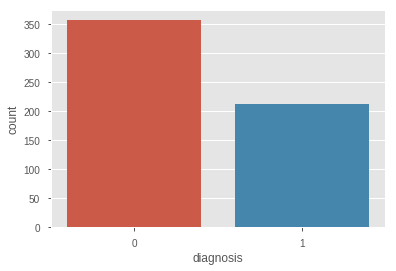

In [148]:
sns.countplot('diagnosis', data=breast_cancer_data)

In [149]:
total = breast_cancer_data['diagnosis'].value_counts()[1] + breast_cancer_data['diagnosis'].value_counts()[0]
print('Malign %: ', (breast_cancer_data['diagnosis'].value_counts()[1]/total)*100)
print('Benign %: ', (breast_cancer_data['diagnosis'].value_counts()[0]/total)*100)

Malign %:  37.258347978910365
Benign %:  62.741652021089635


Benign results account for 62.74% of the diagnosis class. Malignant results account for 37.26% of the diagnosis class. Fortunately, this data set does not suffer from class imbalance.

### Creating Training and Test Sets

Let's split the data set into our training and test sets, which will be pseudo-randomly selected to create a 80-20% split. You will use the training set to train the model and perform some optimization. You will use the test set, which will act as unseen data, to assess model performance.



In [150]:
X = breast_cancer_data.iloc[:, breast_cancer_data.columns != 'diagnosis']
Y = breast_cancer_data.iloc[:, breast_cancer_data.columns == 'diagnosis']

In [151]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state=42)

When using this method for machine learning, always be wary of utilizing your test set to create models. Data leakage is a common problem that can result in overfitting.

In [152]:
Y_train = Y_train.values.ravel()
Y_test = Y_test.values.ravel()

## Fitting Random Forest
Now, let's create the model, starting with parameter tuning. Here are the parameters we will be tuning.

### max_depth: 
The maximum splits for all trees in the forest.

### bootstrap: 
An indicator of whether or not we want to use bootstrap samples when building trees.

### max_features: 
The maximum number of features that will be used in node splitting — the main difference I previously mentioned between bagging trees and random forest. Typically, you want a value that is less than p, where p is all features in your data set.

### criterion: 
This is the metric used to asses the stopping criteria for the decision trees.

Once we've instantiated our model, we will go ahead and tune our parameters.

In [153]:
# Set the random state for reproductibility
fit_rf = RandomForestClassifier(random_state=42)

## Hyperparameter Optimization
### GridSearchCV

In [154]:
np.random.seed = 42

# I included the timer to see how long different jobs took; 
# that led me to ultimately decide to use three parallel jobs.
start = time.time()


# let's create a dictionary with parameters we are looking to optimize to create the best model for our data.
param_dictionary = {
    'max_depth':[2,3,4],
    'bootstrap': [True, False],
    'max_features':['auto','sqrt','log2', None],
    'criterion': ['gini', 'entropy']
}

# Setting the n_jobs to 3 tells the grid search to run three jobs in parallel, 
# reducing the time the function will take to compute the best parameters.
cv_random_forest = GridSearchCV(fit_rf, cv=10, param_grid=param_dictionary, n_jobs=3)

cv_random_forest.fit(X_train, Y_train)

print('Best Params for training are: \n', cv_random_forest.best_params_)
end = time.time()

print('Time Taken to compute Grid Search to find best params: {0: .2f}'.format(end-start))

Best Params for training are: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2'}
Time Taken to compute Grid Search to find best params:  5.00


In [155]:
fit_rf.set_params(criterion = 'gini', max_features = 'log2', max_depth = 3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Out-of-Bag Error Rate


Another useful feature of random forest is the concept of an out-of-bag (OOB) error rate. 
Because only two-thirds of the data are used to train each tree when building the forest, 
one-third of unseen data can be used in a way that is advantageous to our accuracy metrics 
without being as computationally expensive as something like cross validation, for instance.

As outlined below, when calculating OOB, two parameters have to be changed. Also, by utilizing a for-loop across a multitude of forest sizes, we can calculate the OOB error rate and use it to asses how many trees are appropriate for our model!



In [156]:
fit_rf.set_params(warm_start=True,
                  oob_score=True)

min_estimators = 15
max_estimators = 1000

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    fit_rf.set_params(n_estimators=i)
    fit_rf.fit(X_train, Y_train)

    oob_error = 1 - fit_rf.oob_score_
    error_rate[i] = oob_error

In [157]:
oob_series = pd.Series(error_rate)

Text(0.5,1,'OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

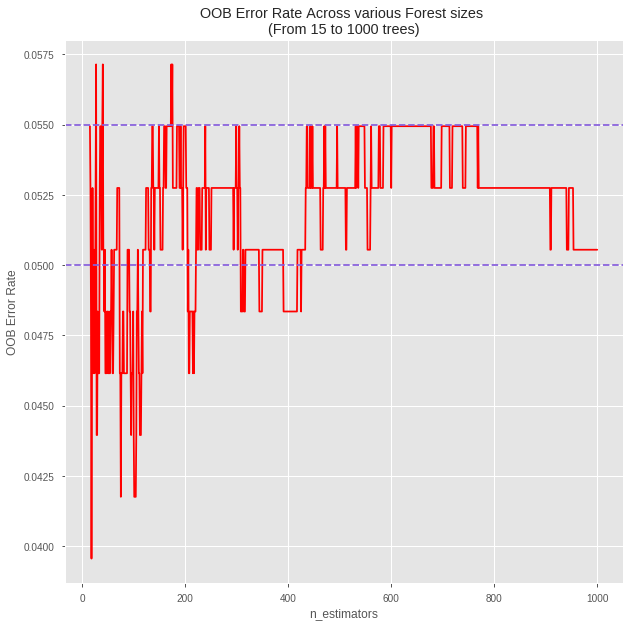

In [158]:
fig, ax = plt.subplots(figsize=(10,10))

oob_series.plot(kind='line', color='red')

plt.axhline(0.055,
            color='#875FDB',
           linestyle='--')
plt.axhline(0.05,
            color='#875FDB',
           linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

The OOB error rate starts to oscillate at around 400 trees, so I will go ahead and use 400 trees in my forest. Using the pandas series object, I can easily find the OOB error rate for the estimator as follows:



In [159]:
print('OOB error rate for 400 trees is {0: .5f}'.format(oob_series[400]))

OOB error rate for 400 trees is  0.04835


Utilizing the OOB error rate that was created with the model gives us an unbiased error rate. Since OOB can be calculated with the model estimation, it's helpful when cross validating and/or optimizing hyperparameters prove to be too computationally expensive.

For the sake of this tutorial, I will go over other traditional methods for optimizing machine learning models, including the training and test error route and cross validation metrics.

## Traditional Training and Test Set Split


In order for this methodology to work, we must set the number of trees calculated using the OOB error rate, and remove the warm_start and oob_score parameters, as well as include the bootstrap parameter.


In [160]:
fit_rf.set_params(n_estimators = 400, warm_start = False, oob_score = False, bootstrap = True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Training the Algorithm

In [161]:
fit_rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Variable Importance


Once we have trained the model, we can assess variable importance. One downside to using ensemble methods with decision trees is that you lose the interpretability a single tree gives. A single tree can outline for us important node splits, as well as variables that were important at each split.


Fortunately, ensemble methods that rely on CART models use a metric to evaluate the homogeneity of splits. Thus, when creating ensembles, these metrics can be utilized to give insight into the important variables used in the training of the model. Two such metrics are gini impurity and entropy. Many people favor gini impurity because it has a lower computational cost than entropy, which requires calculating the logarithmic function.

In [162]:
importance_rf = fit_rf.feature_importances_

indices_rf = np.argsort(importance_rf)[::-1]

In [163]:
def variable_importance(importance, indices):
    """
    Purpose:
    ----------
    Prints dependent variable names ordered from largest to smallest
    based on gini or information gain for CART model.

    Parameters:
    ----------
    names:      Name of columns included in model
    importance: Array returned from feature_importances_ for CART
                   models organized by dataframe index
    indices:    Organized index of dataframe from largest to smallest
                   based on feature_importances_

    Returns:
    ----------
    Print statement outputting variable importance in descending order
    """
    
    print("Feature Ranking")
    
    for f in range(len(names_index)):
        i = f
        print("%d. The feature '%s' has a Mean Decrease in Gini of %f" % (f + 1,names_index[indices[i]],importance[indices[f]]))
        

In [164]:
names_index = names[2:]

In [165]:
variable_importance(importance_rf, indices_rf)

Feature Ranking
1. The feature 'area_worst' has a Mean Decrease in Gini of 0.129856
2. The feature 'perimeter_worst' has a Mean Decrease in Gini of 0.120953
3. The feature 'concave_points_worst' has a Mean Decrease in Gini of 0.115548
4. The feature 'concave_points_mean' has a Mean Decrease in Gini of 0.100136
5. The feature 'radius_worst' has a Mean Decrease in Gini of 0.078047
6. The feature 'concavity_mean' has a Mean Decrease in Gini of 0.062143
7. The feature 'area_mean' has a Mean Decrease in Gini of 0.056556
8. The feature 'radius_mean' has a Mean Decrease in Gini of 0.054567
9. The feature 'perimeter_mean' has a Mean Decrease in Gini of 0.051745
10. The feature 'area_se' has a Mean Decrease in Gini of 0.043261
11. The feature 'concavity_worst' has a Mean Decrease in Gini of 0.038659
12. The feature 'compactness_worst' has a Mean Decrease in Gini of 0.020329
13. The feature 'compactness_mean' has a Mean Decrease in Gini of 0.016163
14. The feature 'texture_worst' has a Mean Decr

We can see here that our top five variables are area_worst, perimeter_worst, concave_points_worst, concave_points_mean, radius_worst.

In [166]:
def variable_importance_plot(importance, indices):
    """
    Purpose
    ----------
    Prints bar chart detailing variable importance for CART model
    NOTE: feature_space list was created because the bar chart
    was transposed and index would be in incorrect order.

    Parameters
    ----------
    importance_desc: Array returned from feature_importances_ for CART
                    models organized in descending order

    indices: Organized index of dataframe from largest to smallest
                    based on feature_importances_
    Returns:
    ----------
    Returns variable importance plot in descending order
    """
    index = np.arange(len(names_index))

    importance_desc = sorted(importance)
    feature_space = []
    for i in range(29, -1, -1):
        feature_space.append(names_index[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 10))

    plt.title('Feature importances for Random Forest Model\
    \nBreast Cancer (Diagnostic)')
    plt.barh(index,
         importance_desc,
         align="center",
         color = '#875FDB')
    plt.yticks(index,
           feature_space)

    plt.ylim(-1, 30)
    plt.xlim(0, max(importance_desc))
    plt.xlabel('Mean Decrease in Gini')
    plt.ylabel('Feature')

    plt.show()
    plt.close()


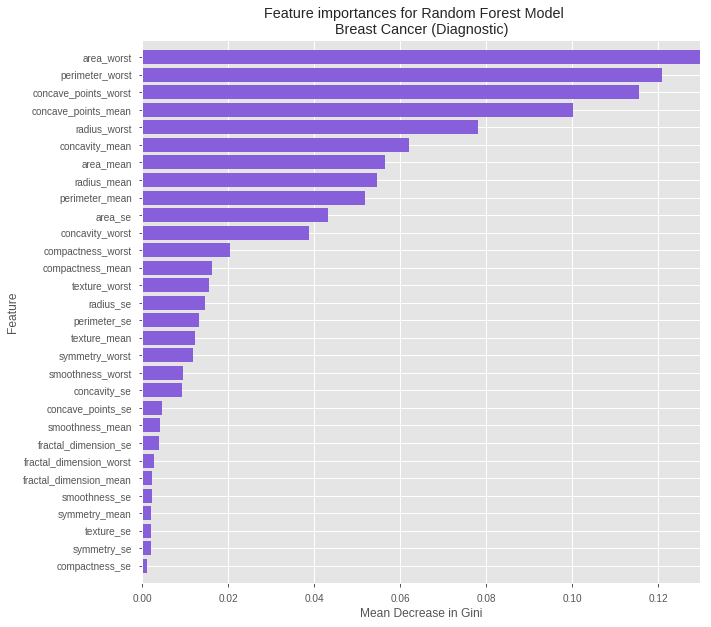

In [167]:
variable_importance_plot(importance_rf, indices_rf)

## Cross Validation


Cross validation is a powerful tool that is used for estimating the predictive power of your model, and it performs better than the conventional training and test set. Using cross validation, we can create multiple training and test sets and average the scores to give us a less biased metric.



Here we are employing K-fold cross validation; more specifically, 10 folds. We are creating 10 subsets of our data on which to employ the training and test set methodology; then we will average the accuracy for all folds to give us our estimation.

In [168]:
def cross_Validation(fit, trainingSet, testSet, print_results = True):
    """
    Purpose
    ----------
    Function helps automate cross validation processes while including
    option to print metrics or store in variable

    Parameters
    ----------
    fit: Fitted model
    training_set:  Data_frame containing 80% of original dataframe
    class_set:     data_frame containing the respective target vaues
                  for the training_set
    print_results: Boolean, if true prints the metrics, else saves metrics as
                  variables

    Returns
    ----------
    scores.mean(): Float representing cross validation score
    scores.std() / 2: Float representing the standard error (derived
            from cross validation score's standard deviation)
    """
    n = KFold(n_splits=10)
    scores = cross_val_score(fit, trainingSet, testSet, cv=n)
    
    
    if(print_results==True):
        print("Accuracy: {0: 0.3f} (+/- {1: 0.3f})"\
          .format(scores.mean(), scores.std() / 2))
    else:
        return scores.mean(), scores.std() / 2
    

In [169]:
cross_Validation(fit_rf, X_train, Y_train, print_results=True)

Accuracy:  0.947 (+/-  0.019)


## Test Set Metrics


In [170]:
predictions_rf = fit_rf.predict(X_test)

In [171]:
test_crossTab = pd.crosstab(index=Y_test, columns=predictions_rf)

In [172]:
test_crossTab = test_crossTab.rename(columns={0: 'Benign', 1: 'Malignant'})
test_crossTab.index = ['Benign', 'Malignant']
test_crossTab.columns.name = 'n=144'

In [173]:
test_crossTab

n=144,Benign,Malignant
Benign,70,1
Malignant,3,40


## Accuracy

In [175]:
accuracy_rf = fit_rf.score(X_test, Y_test)

In [177]:
print('Accuracy on test Set is {0: .4f}'.format(accuracy_rf))

Accuracy on test Set is  0.9649


In [179]:
# Here we calculate the test error rate!

test_error_rate_rf = 1 - accuracy_rf
print('Test Error rate of our model is {0: .4f}'.format(test_error_rate_rf))

Test Error rate of our model is  0.0351


# As you can see, we got a very similar error rate for our test set to the one we got with our OOB, which is a good sign for our model.

## ROC Curve Metrics


A receiver operating characteristic (ROC) curve calculates the false positive rates and true positive rates across different thresholds.